In [2]:
import glob
from datetime import date

import pandas as pd

import altair as alt

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['svg.fonttype'] = 'none'

In [13]:
ministry_mapping = {
    'BBk': 'BBank',
    'BK Amt': 'BK',
    'BMELV': 'BMEL',
    'BMELVV': 'BMEL',
    'BMVBS': 'BMVI',
    'BPrA': 'BPräsA',
    'BMJ': 'BMJV',
    'BMJVV': 'BMJV',
    'BMVI': 'BMVBS',
    'BMU': 'BMUB',
}

def load_dataframe(filename):
    year = int(filename.split('_')[-1].split('.')[0])
    df = pd.read_csv(filename).fillna(0)
    df = df.rename(columns={'Ressort': 'name'})
    df = df[~df['name'].str.contains('Gesamt')]
    df['year'] = date(year, 1, 1)
    df['year'] = pd.to_datetime(df['year'])
    df['gb'] = df['name'].str.contains('GB')
    df['name'] = df['name'].str.replace(' GB', '')
    df['name'] = df['name'].str.replace('*', '', regex=True).str.replace('\d', '', regex=True).str.strip()
    for k, v in ministry_mapping.items():
        df['name'] = df['name'].str.replace('^' + k + '$', v, regex=True)
    df = df.rename(columns={k: k.replace(' ', '_') for k in df.columns})
    return df

filenames = glob.glob('data/ifg_statistik_*.csv')
print(filenames)
df = pd.concat([load_dataframe(filename) for filename in filenames])

df.to_csv('ifg_statistik.csv')
df.head()

['data/ifg_statistik_2006.csv', 'data/ifg_statistik_2015.csv', 'data/ifg_statistik_2016.csv', 'data/ifg_statistik_2014.csv', 'data/ifg_statistik_2020.csv', 'data/ifg_statistik_2011.csv', 'data/ifg_statistik_2018.csv', 'data/ifg_statistik_2013.csv', 'data/ifg_statistik_2019.csv', 'data/ifg_statistik_2009.csv', 'data/ifg_statistik_2007.csv', 'data/ifg_statistik_2008.csv', 'data/ifg_statistik_2017.csv', 'data/ifg_statistik_2010.csv', 'data/ifg_statistik_2012.csv']


,name,Eingang_Erstanträge,Antrag_zurückgenommen,Informationszugang_gewährt,Informationszugang_teilweise_gewährt,Informationszugang_abgelehnt,Erstantrag_noch_in_Bearbeitung,Vorschuss_(0_-_50),Vorschuss_(50_-_100),Vorschuss_(100_-),...,Klageerledigungen_,sonstige_Erledigung.2,Eingang_Widersprüche_,Anträge_in_Bearbeitung_zum_Jahresbeginn,Vorschuss,Widersprüche_in_Bearbeitung_zum_Jahresbeginn,anhängige_Klagen_zum_Jahresbeginn,Höhe_der_Auslagen_(unter_50_),Höhe_der_Auslagen_(50_-_100_),Höhe_der_Auslagen_(>_100_)
0,BK,38.0,2.0,9.0,3.0,16.0,8.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BK,13.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BMAS,18.0,0.0,7.0,3.0,1.0,7.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BMAS,117.0,4.0,72.0,7.0,20.0,14.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,AA,131.0,7.0,67.0,14.0,37.0,6.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df['name'].value_counts()

BMAS      30
BMVg      30
BMF       30
BKM       30
BMUB      30
BMWi      30
BMFSFJ    30
BMG       30
BMJV      30
AA        30
BMBF      30
BMEL      30
BMI       29
BMVBS     29
BK        29
BMZ       15
BPA       15
BPräsA    11
BBank     10
BfDI      10
BT        10
BR         9
BRH        9
BVerfG     6
Name: name, dtype: int64

In [8]:
fds_df = pd.read_csv('fds_stat.csv')
fds_df['year'] = pd.to_datetime(fds_df['year'], format='%Y')
# df = df.merge(fds_df, on=['name', 'gb', 'year'], how='left')

FileNotFoundError: [Errno 2] No such file or directory: 'fds_stat.csv'

In [5]:
# fds_stat = df[['name', 'gb', 'year', 'Eingang Erstanträge', 'total_count']][df.year.dt.year >= 2011]
# fds_stat.head()

In [6]:
# fds_stat['no_fds'] = fds_stat['Eingang Erstanträge'] - fds_stat['total_count']

In [7]:
# fds_stat.groupby(['year'])[['total_count', 'no_fds']].sum().plot(kind='bar', stacked=True)

In [8]:
# fds_stat.groupby(['year'])[['total_count', 'no_fds']].sum().plot(kind='bar')

## Eingang Erstanträge über die Jahre

(0.0, 58864.85)

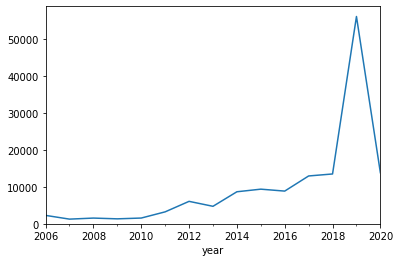

In [15]:
df.groupby('year')['Eingang_Erstanträge'].sum().plot()
plt.ylim(0)

name     AA  BBank     BK   BKM    BMAS   BMBF     BMEL     BMF  BMFSFJ  \
year                                                                      
2006  131.0    NaN   51.0   7.0   135.0    6.0    164.0   171.0    44.0   
2007   88.0    NaN   27.0  10.0    81.0   10.0     53.0   135.0    12.0   
2008  132.0    NaN   22.0   9.0    71.0   11.0     39.0   493.0    14.0   
2009  139.0    NaN    2.0  10.0    84.0   10.0     71.0   295.0    43.0   
2010  158.0    NaN   31.0  21.0   160.0   10.0     25.0   248.0    38.0   
2011  153.0   13.0   37.0  24.0   335.0   30.0     51.0  1179.0    20.0   
2012  147.0   13.0  790.0  15.0   359.0   29.0     47.0  2967.0    33.0   
2013  147.0    5.0   90.0  21.0   507.0   40.0     56.0  1390.0    64.0   
2014  206.0   10.0  118.0  35.0   614.0   27.0     73.0  5191.0    45.0   
2015  349.0   14.0  237.0  51.0   934.0   46.0     78.0  4170.0    59.0   
2016  251.0   41.0  373.0  52.0  1286.0   65.0     84.0  3606.0    95.0   
2017  341.0   38.0  278.0

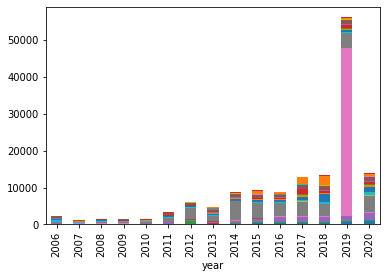

In [19]:
ax = df.groupby([df.year.dt.year, 'name'])['Eingang_Erstanträge'].sum().unstack().plot(kind='bar', stacked=True)
ax.legend().set_visible(False)
print(df.groupby([df.year.dt.year, 'name'])['Eingang_Erstanträge'].sum().unstack())

Chart({
  data:     Abhilfe  Abweisung  Antrag_zurückgenommen  \
  0       0.0        0.0                    NaN   
  1       0.0        0.0                    NaN   
  3       2.0        1.0                    NaN   
  4      26.0        2.0                    NaN   
  6       0.0        5.0                    NaN   
  7       0.0        0.0                    NaN   
  9       2.0        1.0                    NaN   
  10      2.0        1.0                    NaN   
  12      0.0        2.0                    NaN   
  13      0.0        0.0                    NaN   
  15      0.0        1.0                    NaN   
  16      4.0        7.0                    NaN   
  18      0.0        0.0                    NaN   
  19      3.0        2.0                    NaN   
  21      0.0        0.0                    NaN   
  22      0.0        0.0                    NaN   
  24      0.0        0.0                    NaN   
  25      0.0        0.0                    NaN   
  27      0.0    

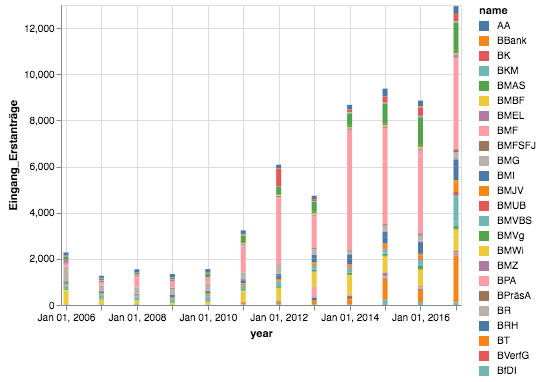

In [23]:
alt.Chart(df).mark_bar().encode(
    color='name',
    x='year',
    y='Eingang_Erstanträge',
    tooltip='name'
).interactive()

In [20]:
cols = ['Informationszugang_gewährt', 'Informationszugang_teilweise_gewährt', 'sonstige_Erledigung', 'Informationszugang_abgelehnt']

out_group = df.groupby(['name', 'year'])[cols].sum()

out_group['granted'] = out_group[['Informationszugang_gewährt', 'Informationszugang_teilweise_gewährt']].sum(1)
out_group['not_granted'] = out_group[['Informationszugang_abgelehnt', 'sonstige_Erledigung']].sum(1)
out_group['count'] = out_group['granted'] + out_group['not_granted']
out_group['transparency'] = out_group['granted'] / out_group['count'] * 100
out_group['transparency'] = out_group['transparency'].round()
out_group = out_group.reset_index()
out_group = out_group.drop(cols, axis=1)
out_group['year'] = pd.to_datetime(out_group['year']).dt.year
out_group.to_csv('data.csv', index=False)
out_group.head()

,name,year,granted,not_granted,count,transparency
0,AA,2006,81.0,37.0,118.0,69.0
1,AA,2007,56.0,28.0,84.0,67.0
2,AA,2008,94.0,32.0,126.0,75.0
3,AA,2009,98.0,35.0,133.0,74.0
4,AA,2010,102.0,46.0,148.0,69.0


In [21]:
cols = [
    'Erledigungen_und_Bescheide', 'Eingang_Erstanträge',
    'Informationszugang_gewährt', 'Informationszugang_teilweise_gewährt',
    'sonstige_Erledigung', 'Informationszugang_abgelehnt'
]

out_group = df[df['year'].dt.year == 2017].groupby(['name'])[cols].sum()

out_group['rate'] = out_group['Erledigungen_und_Bescheide'] / out_group['Eingang_Erstanträge']

out_group['granted'] = out_group[['Informationszugang_gewährt', 'Informationszugang_teilweise_gewährt']].sum(1)
out_group['not_granted'] = out_group[['Informationszugang_abgelehnt', 'sonstige_Erledigung']].sum(1)
out_group['count'] = out_group['granted'] + out_group['not_granted']
out_group['transparency'] = out_group['granted'] / out_group['count'] * 100
out_group['transparency'] = out_group['transparency'].round()
out_group = out_group.reset_index()
out_group = out_group.drop(cols, axis=1)
out_group.head()


alt.Chart(out_group).mark_circle().encode(
    y='rate',
    x='transparency',
    size='count',
    color='count',
    tooltip='name'
).interactive()

alt.Chart(...)